In [ ]:
!pip install multidict

---
#### Relancer l'environnement d'exécution
---

In [ ]:
from google.colab import files
import os

# Si le dossier est déjà monté dans l'environnement d'exécution, on passe
try:
  os.chdir('DistorsionCom')
except:
  !git clone https://github.com/Patent2net/DistorsionCom.git
  print("Dossier monté, vous pouvez continuer l'exécution")
  os.chdir('DistorsionCom')

from outils import * 

stockageEntree = "/content/DistorsionCom"
stockageSortie = "/content/DistorsionCom"

fatal: destination path 'DistorsionCom' already exists and is not an empty directory.



---
Personnalisation

> Ces cellules permettent de réaliser les traitements à partir de son propre espace de stockage. A n'exécuter que dans ce cas en adaptant les dossiers d'entrée et sortie. NE PAS EXECUTER SAUF A PERSONNALISER LES TRAITEMENTS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Récupérer les sorties sur son drive (créer un dossier "OUT")
stockageSortie = "/content/drive/MyDrive/OUT"

In [ ]:
# Récupérer les entrées sur son drive
stockageEntree = "/content/drive/MyDrive/OUT"

---

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Récupérer les sorties sur son drive (créer un dossier "OUT")
stockageSortie = "/content/drive/MyDrive"

---

In [ ]:
import multidict as multidict
import os, pickle
from PIL import Image
from os import path
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator, get_single_color_func
from matplotlib.patches import Patch #NEW
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm, colors

%matplotlib inline


# Chargement des données issues de TraiteContenus.ipynb
> On charge les données traitées par Spacy dans TraiteContenus.ipynb pour réaliser les opérations de comparaisons par visualisation des champs lexicaux

In [ ]:
fichierEntree = stockageEntree + '/OUT/ContenusTraites/' +"verbesSites.pkl"
with open(fichierEntree, 'rb') as fictemp: #on récupère tous les contenus dans pickle
  verbes = pickle.load(fictemp)

fichierEntree = stockageEntree + '/OUT/ContenusTraites/' +'nomsSites.pkl'
with open (fichierEntree, 'rb') as fictemp: #on récupère tous les contenus dans pickle
  noms = pickle.load(fictemp)

fichierEntree = stockageEntree + '/OUT/ContenusTraites/' +'adjectifsSites.pkl'
with open(fichierEntree, 'rb') as fictemp: #on récupère tous les contenus dans pickle
  adjectifs = pickle.load(fictemp)

fichierEntree = stockageEntree + '/OUT/ContenusTraites/' +'spacySites.pkl'
with open(fichierEntree, 'rb') as fictemp: #on récupère tous les contenus dans pickle
  dicoEtiquettage = pickle.load(fictemp)


In [ ]:
verbes.keys()

dict_keys(['Gouv', 'parcs', 'organisations', 'oTourism', 'Services', 'Hebergement', 'restauration', 'locations', 'mairies'])

In [ ]:
dicoEtiquettage.keys()

dict_keys(['parcs', 'organisations', 'oTourism', 'Services', 'Gouv', 'Hebergement', 'restauration', 'locations'])

# Catégories de site, différents et communs



In [ ]:
# création de la palette de couleurs
palette = Palette(dicoEtiquettage.keys())

In [ ]:
# les catégories retenues
catGram = ['ADJ', "VERB", "NOUN"]

## Dénombrement des termes

In [ ]:
CountMots = dict()
for ndf in dicoEtiquettage.keys():
  CountMots[ndf] = dict()
for ndf in dicoEtiquettage.keys():
  CountMots[ndf]["VERB"] = Counter(verbes [ndf])
  CountMots[ndf]["ADJ"] = Counter(adjectifs [ndf])
  CountMots[ndf]["NOUN"] = Counter(noms [ndf])

In [ ]:
# version cibléee sur les caractères alpha
CountMots2 = dict()
for ndf in dicoEtiquettage.keys():
  CountMots2[ndf] = dict()
  for cat in catGram:
    CountMots2[ndf][cat] = {mot:CountMots[ndf][cat][mot] for mot in CountMots[ndf][cat].keys() if mot.isalpha() or '-' in mot}

## Normalisation
> Pour pouvoir comparer les représentations il faut que la quantité de mots relative dans chacun des espaces (ndf) soit comparable. On normalise ici en % de cette quantité par catégorie grammaticale.

Notes : 
1. on pourrait le faire sur la somme des catégories mais celles-ci sont trop différentes (en nombre de sites).

2. Ce ne sera probablement pas suffisant : il faudra normaliser aussi le nombre de sites en entrée de chaque catégorie

In [ ]:
# normalisation relative au type de site
CountMotsNorm = dict()
for ndf in dicoEtiquettage.keys():
  CountMotsNorm[ndf] = dict()
  for cat in catGram:
    total = sum(CountMots[ndf][cat].values())
    CountMotsNorm[ndf][cat] = {mot: CountMots[ndf][cat][mot]*100.0/total for mot in CountMots[ndf][cat].keys() if mot.isalpha() or '-' in mot}
    

In [ ]:
# normalisation sur toute la représentation

CountMotsNorm2 = CountMotsNorm

for ndf in dicoEtiquettage.keys():
  total = sum([CountMots[ndf][cat][mot] for cat in catGram for mot in CountMots[ndf][cat].keys()])


  for cat in catGram:
    totalClasses = sum([CountMots[ndf][cat][mot] for mot in CountMots[ndf][cat].keys()])
    CountMotsNorm2[ndf][cat] = {mot:int((CountMots[ndf][cat][mot]*1.0/totalClasses)*total) for mot in CountMots[ndf][cat].keys() if mot.isalpha()}
 

In [ ]:
CountMots 

**Note:** pour les backlinks nous utiliserons une représentation TDIDF

## Séparation des termes
> 3 blocs séparés dans 3 variables distinguant les catégories grammaticales : 

1. les mots communs à toutes les catégories de sites (mots bateaux) :  *communsExclusifs*

2. les mots communs à deux catégories de sites : *communs*

3. les mots exclusifs à chaque catégorie de site : *diff*

In [ ]:
communsExclusifs = dict() # pour chaque catégorie, les termes communs à TOUS

for ndf in CountMots.keys():
  communsExclusifs[ndf] = dict()

for ndf in CountMots.keys():
  autres = list(CountMots.keys())
  autres.remove(ndf) 
  for cat in catGram:
    # initialisation
    communsExclusifs[ndf][cat] = set(CountMots[ndf][cat].keys()).intersection(set(CountMots[autres [0]][cat].keys()))
  for cat in CountMots[ndf].keys():
    for ens in autres:
      #print (ndf, '  ', ens, '  ',cat, '  ',len(CountMots [ens][cat].keys()))
      communsExclusifs[ndf][cat] = communsExclusifs[ndf][cat].intersection(set(CountMots[ens][cat].keys()))
    #print(len (communsExclusifs [ndf][cat]))

In [ ]:
communs = dict() # pour chaque catégorie, les termes communs à au moins deux

for ndf in CountMots.keys():
  communs[ndf] = dict()

for ndf in CountMots.keys():
  autres = list(CountMots.keys())
  autres.remove(ndf) 
  for cat in catGram:
    # initialisation
    communs[ndf][cat] = set()
  for cat in CountMots[ndf].keys():
    for ens in autres:
      communs[ndf][cat] = communs[ndf][cat] .union(set(CountMots[ndf][cat].keys()) .intersection(set(CountMots[ens][cat].keys())))
      #print (ndf, '  ', ens, '  ',cat, '  ',len(CountMots [ens][cat].keys()), len(communs [ndf][cat]))
# on évite aussi ceux qui sont communs à tous retrouvés précédemment
for ndf in CountMots.keys():  
  for cat in catGram:
    #print(len (communs [ndf][cat]))
    communs[ndf][cat] = [truc for truc in communs[ndf][cat] if truc not in communsExclusifs[ndf][cat]]
    #print(len (communs [ndf][cat]))

In [ ]:
communs[ndf]


In [ ]:
dicoEtiquettage['Services'].keys()

dict_keys(['MISC', 'LOC', 'PER', 'ORG', 'NOUN', 'ADV', 'ADJ', 'VERB'])

In [ ]:
CountMots[ens].keys()

dict_keys(['VERB', 'ADJ', 'NOUN'])

In [ ]:
diff = dict()
for ndf in CountMots.keys():
  diff[ndf] = dict()

for ndf in CountMots.keys(): 
  for cat in CountMots[ndf].keys():
    #diff [ndf] [cat] = set()
    diff[ndf][cat] = [mot for mot in CountMots[ndf][cat].keys() if mot not in communs[ndf][cat] and mot not in communsExclusifs[ndf][cat]]



In [ ]:
for tip in diff.keys():
  print (diff[tip])

{'VERB': ['nourrir', 'disparaitre', 'enveloppe', 'percevoir', 'éclore', 'reconstruire', 'réouvrir', 'impacter', 'rapprocher', 'procéder', 'contribuer', 'recouvrir', 'arbore', 'tâcheter', 'consituer', 'délecter', 'brûler'], 'ADJ': ['mâle', 'roux', 'barbu', 'inc', '7èm', 'étoilé', 'mellifère', 'bis', 'automnal', 'terrible', 'alternatif', '3èm', 'savoyard', 'adjoint', 'pédagogique', 'brun', 'géologique', 'endémique', 'autochtone', 'humide', 'virtuel', 'caribéen', 'amazonien', 'orange', 'creux', 'sommital'], 'NOUN': ['bouquetin', 'rumination', 'aiguille', 'grive', 'escargot', 'reproduction', 'gypaète', 'collégien', 'recrutement', 'relance', 'tatou', 'éleveur', 'pyrénée', 'absence', 'éclair', 'environnementa', 'bp736', 'réglementation', 'agro-pastoralisme', 'pollinisateur', 'planton', 'haie', 'organisateur', 'coureur', 'raton', 'laveur', 'vautour', 'moine', 'confection', 'insecte', 'bio-indicatrice', 'effectif', 'ecrevisse', 'secteur', 'cévenne', 'émission', 'palais', 'standard', 'tempête',

## Consistance

> spacy peut générer des erreurs de catégorisation, d'autant plus que nos textes sont extraits d'une page Web : la structure textuelle est rompue. De fait, certains termes peuvent être, selon les sites, affectés à des catégories grammaticales différentes.

Le choix est fait de les éliminer. Le code ci-dessous les présente et les élimine

In [ ]:
# test de consistance et séparation des mots entre les différents types
# a rééxécuter deux fois
test = [mot for cle in diff.keys() for cat in catGram for mot in diff[cle][cat] if mot in communs[cle][cat]]
print(test, " <-- termes communs entre diff et communs (doit être vide)")
print(" termes communs de chaque type de site pour toute catégorie grammaticale avec n'importe quel autre type (devrait être vide)")
for cle in diff.keys():
  autres = list(diff.keys())
  autres.remove(cle)
  autresMots = [mot for key in autres for cat in catGram for mot in diff[key][cat]]
  test = [mot for cat in catGram for mot in diff[cle][cat] if mot in autresMots]
  # type de site, terme et catégorie grammaticale
  print (cle, test)
  for truc in test:
    for cat in catGram:
      for key in diff.keys():
          if truc in diff[key][cat]:
            print (cle, truc, key, cat)
            # suppression 
            diff [key][cat].remove(truc)



[]  <-- termes communs entre diff et communs (doit être vide)
 termes communs de chaque type de site pour toute catégorie grammaticale avec n'importe quel autre type (devrait être vide)
parcs ['bis', 'adjoint', 'orange', 'standard']
parcs bis parcs ADJ
parcs bis Hebergement NOUN
parcs adjoint parcs ADJ
parcs adjoint organisations NOUN
parcs orange parcs ADJ
parcs orange Hebergement NOUN
parcs standard Hebergement ADJ
parcs standard parcs NOUN
organisations ['bénévole', 'conjoint']
organisations bénévole organisations ADJ
organisations bénévole Services NOUN
organisations conjoint organisations ADJ
organisations conjoint Services NOUN
oTourism ['complexe']
oTourism complexe Services ADJ
oTourism complexe oTourism NOUN
Services ['pointu', 'déco', 'titulaire', 'attacher', 'diversifier', 'fixe', 'pro', 'gourmet', 'minimum', 'check', 'vivant', 'fou', 'maitre']
Services pointu Services ADJ
Services pointu Hebergement NOUN
Services déco Services ADJ
Services déco restauration NOUN
Services ti

# Visualisation des résultats

## Préparatifs

Une palette de couleur (fonction du nombre de catégories que l'on souhaite représenter). Puis la coloration des mots, ie. l'application d'une couleur par mot.

In [ ]:
# on génère la palette de couleurs

palette = Palette(dicoEtiquettage.keys()) 

In [ ]:
# on affecte les mots de chaque classe à une couleur de la palette
couleursMots = dict()
motsCouleurs = dict()
for cle in dicoEtiquettage.keys():
  couleursMots[colors.to_hex((palette[cle]))] = []
for cle in dicoEtiquettage.keys():  
  for cat in catGram:
    for mot in diff[cle][cat]:
      couleursMots[colors.to_hex((palette[cle]))].append(mot) # à une couleur hexa des mots
      motsCouleurs[mot] = (int(palette[cle][0]*255), int(palette[cle][1]*255), int(palette[cle][2]*255)) # à un mot une couleur RVB


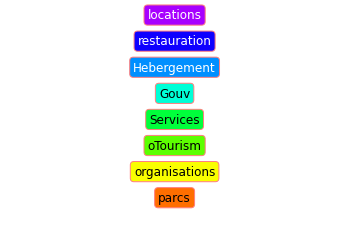

<Figure size 432x288 with 0 Axes>

In [ ]:
# légende à priori
y = 0

for cle in palette.keys():
  #print(cle, " ---> ", colors.to_hex(palette[cle]), int(palette[cle][2]))
  y += .12
  plt.text(0.5, y, cle, size=12, rotation=0,
         ha="center", va="center", color = (0+int(palette[cle][2]) , 0 +int(palette[cle][2]), 0 +int(palette[cle][2])),
         bbox=dict(boxstyle="round",
                   ec=(1., 0.5 , 0.5 ),
                   fc=palette[cle],
                   )
         )
plt.axis("off")
plt.show()
plt.savefig(stockageSortie + "/OUT/legendeTypSites.png")

## Filtrage
> Les représentations qui suivent sont fonction de paramètres de seuillage mais peuvent nécessiter d'exclure des termes qui auraient échappé aux filtrages précédents, proviennent d'erreurs de TAL ou sont simplement triviaux (dans notre cas "url et include" proviennent des erreurs de parser, gien est probablement une erreur de lemmatisation de Spacy, la presqu'ile de Giens a été considérée comme un nom commun, les mots en anglais d'un site rescapé du détecteur de langues

In [ ]:
# Variable d'exclusion de termes pour les représentations. Aucun des mots ci-dessous ne sera représenté
aExclure = 'url include will delayed outdoor gien type per ktm insert inc déc' .split()

## Représentations mixant plusieurs catégories de sites

> Les représentations ci-dessous n'ont pas vraiment de sens, mêlant toutes les catégories de sites qui contiennent à la fois des nombres de sites différents et très probablement des catégories de sites pas forcément optimales par leur diversité dans notre cas d'étude. 

Par ex. les classes hébergement et restauration auraient pu être séparées pour que toute entité mêlant les deux services soit vue comme relevant des deux classes. Dans le cas présent la non disjonction stricte des deux classes laisse la représentation des sites dépendante du nombre d'occurences de termes relevant d'une classe ou d'une autre sur simple effet de bord.

In [ ]:
tempo = dict()
seuil = 2 # occurence à partir de laquelle démarrer

for ndf in dicoEtiquettage.keys():
  for cat in catGram:
    tempo[cat] = ""
    seuil2 = max([CountMotsNorm[ndf][cat][mot] for mot in CountMotsNorm[ndf][cat]]) #seuil
    for mot in CountMotsNorm[ndf][cat].keys():
      if CountMotsNorm[ndf][cat][mot] >seuil and CountMotsNorm[ndf][cat][mot] <seuil2 and mot not in aExclure:
        tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
    print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    makeImage(tempo[cat], palette, couleursMots)

## Représentations sur les mots exclusifs de la catégorie

In [ ]:
tempo = dict()
seuil = 0 # occurence à partir de laquelle démarrer
for ndf in dicoEtiquettage.keys():
  for cat in catGram:
    tempo[cat] = ""
    for mot in CountMotsNorm[ndf][cat].keys():
      if CountMotsNorm[ndf][cat][mot] >seuil  and mot in diff[ndf][cat] and mot not in aExclure:
        tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
    print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    makeImage(tempo[cat], palette, couleursMots)

## Représentations mixant plusieurs catégories de sites

In [ ]:
# 2e méthode
seuil1 = 5
seuil2 = 15
tempo = dict()
for cat in catGram:
  tempo[cat] = dict() # reconstruction du compteur de mots qui contiendra les mots à représenter et leur occ
  for ndf in CountMots.keys():
      for mot in diff[ndf][cat]:
        if mot in CountMotsNorm [ndf][cat].keys():
          if CountMotsNorm[ndf][cat][mot] > seuil1 and CountMotsNorm[ndf][cat][mot] < seuil2 : # en mettant inférieur --> signaux faibles
                                                  # en mettant supérieur --> signaux forts ou évidents
                                                  # écrétage entre seuil1 et 2
            tempo[cat][mot] = CountMotsNorm[ndf][cat][mot]
          else:
            pass
      #print (len(tempo.split()))
  
  makeImage2(tempo[cat], palette, couleursMots, leg = False) # true pour legend
  print(cat)

## Représentations de la totalité des mots d'une catégorie sauf mots communs à tous

> en excluant les trivaux (occurrence maximale)

In [ ]:
aExclure += 'décembre novembre détail suite vendredi nov'.split()

In [ ]:
tempo = dict()
seuil = 0 # occurence à partir de laquelle démarrer

for ndf in dicoEtiquettage.keys():
  for cat in catGram:
    tempo[cat] = ""
    seuil2 = max([CountMotsNorm[ndf][cat][mot] for mot in CountMotsNorm[ndf][cat]]) #seuil
    for mot in CountMotsNorm[ndf][cat].keys():
      if CountMotsNorm[ndf][cat][mot] >seuil and CountMotsNorm[ndf][cat][mot] <seuil2 and mot not in aExclure and (mot in diff[ndf][cat] or mot in communs[ndf][cat]):
        tempo[cat] += (mot + ' ') * CountMots[ndf][cat][mot]
    print (ndf, cat, len(tempo[cat].split()), len(set(tempo[cat].split())))
    makeImage(tempo[cat], couleursMots, palette)